<a href="https://colab.research.google.com/github/ucheokechukwu/Stock-Prediction-with-Media-Sentiment-Analysis-/blob/main/src/Feature_Engineering_Baseline_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bitcoin data source: https://coincodex.com/crypto/bitcoin/historical-data/

NFLX data source:

- https://www.nasdaq.com/market-activity/stocks/nflx/historical

- https://finance.yahoo.com/quote/nflx/history/?guccounter=1

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tensorflow_addons.metrics import RSquare
# model.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()])


In [11]:
data = pd.read_csv('/content/data/nflx.csv',
                   parse_dates = ['Date'],
                   index_col = ['Date']).sort_index(ascending=True)['Close'].to_frame()
data

,Close
Date,
2022-06-13,169.690002
2022-06-14,167.539993
2022-06-15,180.110001
2022-06-16,173.350006
2022-06-17,175.509995
...,...
2023-06-07,399.769989
2023-06-08,409.369995
2023-06-09,420.019989


In [12]:
data.tail()

,Close
Date,
2023-06-07,399.769989
2023-06-08,409.369995
2023-06-09,420.019989
2023-06-12,423.970001
2023-06-13,432.649994


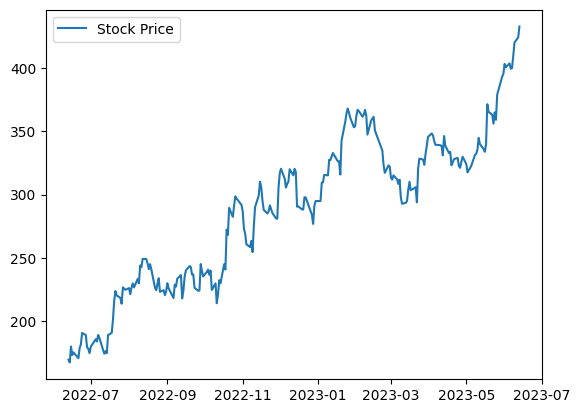

In [13]:
import matplotlib.pyplot as plt
plt.plot(data, label='Stock Price')
plt.legend()
plt.show()

## Creating Train & Test Splits

In [14]:
split = int(0.8 * len(data))
train, test = data[:split], data[split:]

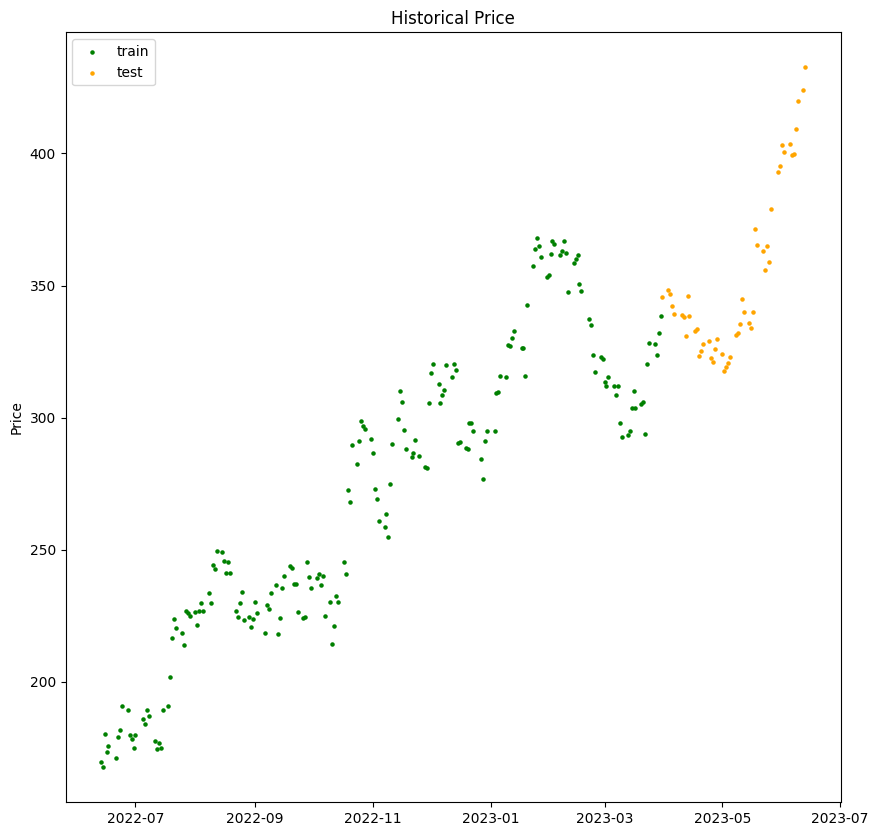

In [16]:
# plotting train, test data
plt.figure(figsize=(10,10))

plt.scatter(train.index, train, color='green', label='train', s=5)
plt.scatter(test.index, test, color='orange', label='test', s=5)
plt.ylabel('Price')
plt.legend()
plt.title('Historical Price')
plt.show()

# Baseline Model: Naive Forecast

X[t+1] = X[t]

In [35]:
# shifting the data by one day

pred = test.shift(periods=1, freq='B')
display(pred.head())
display(pred.tail())
test.tail()


,Close
Date,
2023-04-03,345.480011
2023-04-04,348.279999
2023-04-05,346.750000
2023-04-06,342.350006
2023-04-07,339.329987


,Close
Date,
2023-06-08,399.769989
2023-06-09,409.369995
2023-06-12,420.019989
2023-06-13,423.970001
2023-06-14,432.649994


,Close
Date,
2023-06-07,399.769989
2023-06-08,409.369995
2023-06-09,420.019989
2023-06-12,423.970001
2023-06-13,432.649994


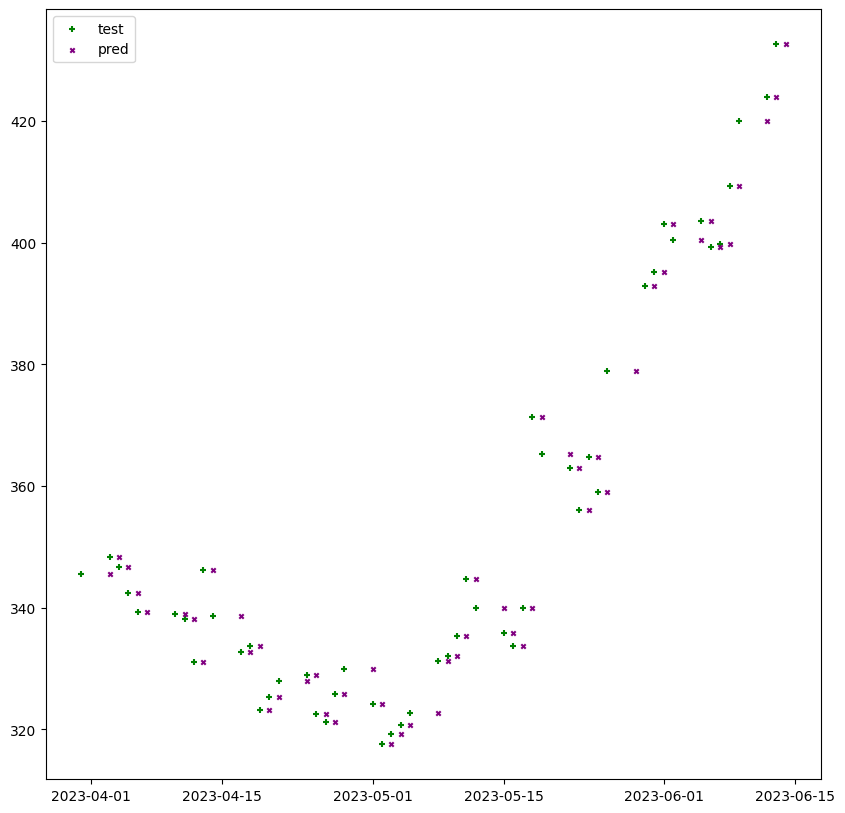

In [36]:
# visualizing this
plt.figure(figsize=(10,10))
# plt.scatter(train.index, train, color='green', label='train', s=4)
plt.scatter(test.index, test, color='green', label='test', s=20, marker="+")
plt.scatter(pred.index, pred, color='purple', label='pred', s=10, marker="x")
plt.legend()

## Evaluating performance

In [47]:
from sklearn.metrics import r2_score

def metrics(y_true, y_pred, period=1):
  """
  Implement MASE (mean_absolute_scaled error & r2 score).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])))
  # our seasonality is 1 day (hence the shifting of 1 day)
  return mae / mae_naive_no_season, r2_score(y_true, y_pred)

In [42]:
len(test.values[1:]), len(pred.values[:-1])

(50, 50)

In [49]:
error_dict = {}
error_dict['baseline'] = metrics(y_true = test.values[1:],
                                            y_pred = pred.values[:-1])
error_dict

{'baseline': (<tf.Tensor: shape=(), dtype=float64, numpy=0.989607461898346>,
  0.9388946698604538)}

## Windowing Dataset

To turn time series into supervised learning problem using the **Sliding Windows** approach.

In [50]:
display(data.head())

,Close
Date,
2022-06-13,169.690002
2022-06-14,167.539993
2022-06-15,180.110001
2022-06-16,173.350006
2022-06-17,175.509995


In [53]:
def make_windows(df, window_size=3, horizon=1):
    """
    Input: 1-D time series
    output: X 2D time series of window_size
    y: 1D time series lagged by horizon
    """
    data = df.copy()

    windows = list(data.rolling(window=window_size))[window_size:]
    window_data = pd.concat([pd.DataFrame(window.T.values) for window in windows])
    window_data.index = data.index[window_size:]

    X = window_data[:-horizon].shift(horizon, freq='B')
    y = data[window_size+horizon:]
    print(f"The shape of X is {X.shape} and the size of y is {y.shape}")
    print("Testing that the indices are aligned:")

    display(pd.merge(X, y, left_index=True, right_index=True))
    return X, y

In [62]:
X, y = make_windows(data, 3, 1)

The shape of X is (248, 3) and the size of y is (248, 1)
Testing that the indices are aligned:


,0,1,2,Close
Date,,,,
2022-06-17,167.539993,180.110001,173.350006,175.509995
2022-06-22,173.350006,175.509995,170.910004,178.889999
2022-06-23,175.509995,170.910004,178.889999,181.710007
2022-06-24,170.910004,178.889999,181.710007,190.850006
2022-06-27,178.889999,181.710007,190.850006,189.139999
...,...,...,...,...
2023-06-07,400.470001,403.540009,399.290009,399.769989
2023-06-08,403.540009,399.290009,399.769989,409.369995
2023-06-09,399.290009,399.769989,409.369995,420.019989


# Model 1

A single dense layer with
- 128 hidden units and ReLU(rectified linear unit) activation

An output layer with
- linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs


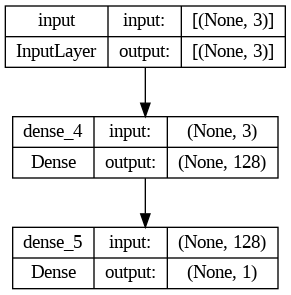

In [55]:
# set random seed for reproducible results
tf.random.set_seed(88)
# construct model
input = layers.Input(shape=(3,), name='input')
hidden = layers.Dense(128, activation='relu')(input)
output = layers.Dense(1, activation='linear')(hidden)


model1 = tf.keras.Model(inputs=input,
                         outputs=output,
                         name="model_1")

plot_model(model1, show_shapes=True)

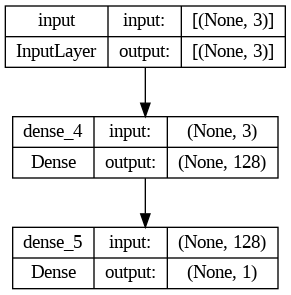

In [56]:
plot_model(model1, show_shapes=True)

In [63]:
# function to train test split the X and y
def train_test_splits(X, y, test_split=0.2):
    """
    Input: X and y
    Output: X_train, X_test, y_train, y_test in that order
    """
    split = round(len(X) * (1-test_split))
    # returns in order: X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    display (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_splits(X, y, test_split=0.2)

(198, 3)

(50, 3)

(198, 1)

(50, 1)

In [64]:
# modelling checkpoint
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=4)

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_num, filepath="model_checkpoints"):
    return ModelCheckpoint(filepath=os.path.join(filepath, 'model_num'),
                                            verbose=0,
                                            save_best_only=True)

In [65]:
# train_dataset, test_dataset = convert_to_tfDataset(X,y, batch=128)
# Compile model
# model1.compile(loss="mae",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["mae"])

model1.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()])

In [66]:
# Fit model
model1.fit(X_train,
           y_train,
           epochs=100,
           verbose=1,
           batch_size=128,
           validation_data=(X_test, y_test),
           callbacks=[early_stop]
           ) # create ModelCheckpoint callback to save best model

Epoch 1/100
2/2 [==============================] - 3s 1s/step - loss: 77448.1797 - r_square: -26.2219 - val_loss: 93561.6406 - val_r_square: -90.1072
Epoch 2/100
2/2 [==============================] - 0s 122ms/step - loss: 54602.4141 - r_square: -18.1920 - val_loss: 71303.4141 - val_r_square: -68.4329
Epoch 3/100
2/2 [==============================] - 0s 122ms/step - loss: 41787.3477 - r_square: -13.6877 - val_loss: 55792.3594 - val_r_square: -53.3287
Epoch 4/100
2/2 [==============================] - 0s 60ms/step - loss: 32668.2129 - r_square: -10.4824 - val_loss: 43892.5312 - val_r_square: -41.7411
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 25667.0332 - r_square: -8.0216 - val_loss: 34525.3516 - val_r_square: -32.6196
Epoch 6/100
2/2 [==============================] - 0s 53ms/step - loss: 20141.1445 - r_square: -6.0793 - val_loss: 27009.0059 - val_r_square: -25.3005
Epoch 7/100
2/2 [==============================] - 0s 40ms/step - loss: 15703.3750 - r_squ

In [68]:
metrics(y_test.values, model1.predict(X_test), period=1)

2/2 [==============================] - 0s 5ms/step


(<tf.Tensor: shape=(), dtype=float64, numpy=1.3062383798928205>,
 0.90413405480212)

In [70]:
error_dict['model1'] = metrics(y_true = y_test.values,
                                            y_pred = model1.predict(X_test))
error_dict

2/2 [==============================] - 0s 9ms/step


{'baseline': (<tf.Tensor: shape=(), dtype=float64, numpy=0.989607461898346>,
  0.9388946698604538),
 'model1': (<tf.Tensor: shape=(), dtype=float64, numpy=1.3062383798928205>,
  0.90413405480212)}